In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn.datasets as skd
import pandas as pd

from sklearn.utils import check_random_state
from utrees import UnmaskingTrees

In [2]:
rix = 0
rng = check_random_state(rix)
n_upper = 100
n_lower = 100
n = n_upper + n_lower
data, labels = skd.make_moons(
    (n_upper, n_lower), shuffle=False, noise=0.1, random_state=rix)
data4impute = data.copy()
data4impute[:, 1] = np.nan
X=np.concatenate([data, data4impute], axis=0)
nimp = 1 # number of imputations needed

utmodel = UnmaskingTrees()
utmodel.fit(X)
data_gen_utmodel = utmodel.generate(n_generate=200);
data_impute_utmodel = utmodel.impute(n_impute=nimp)[0, :, :]

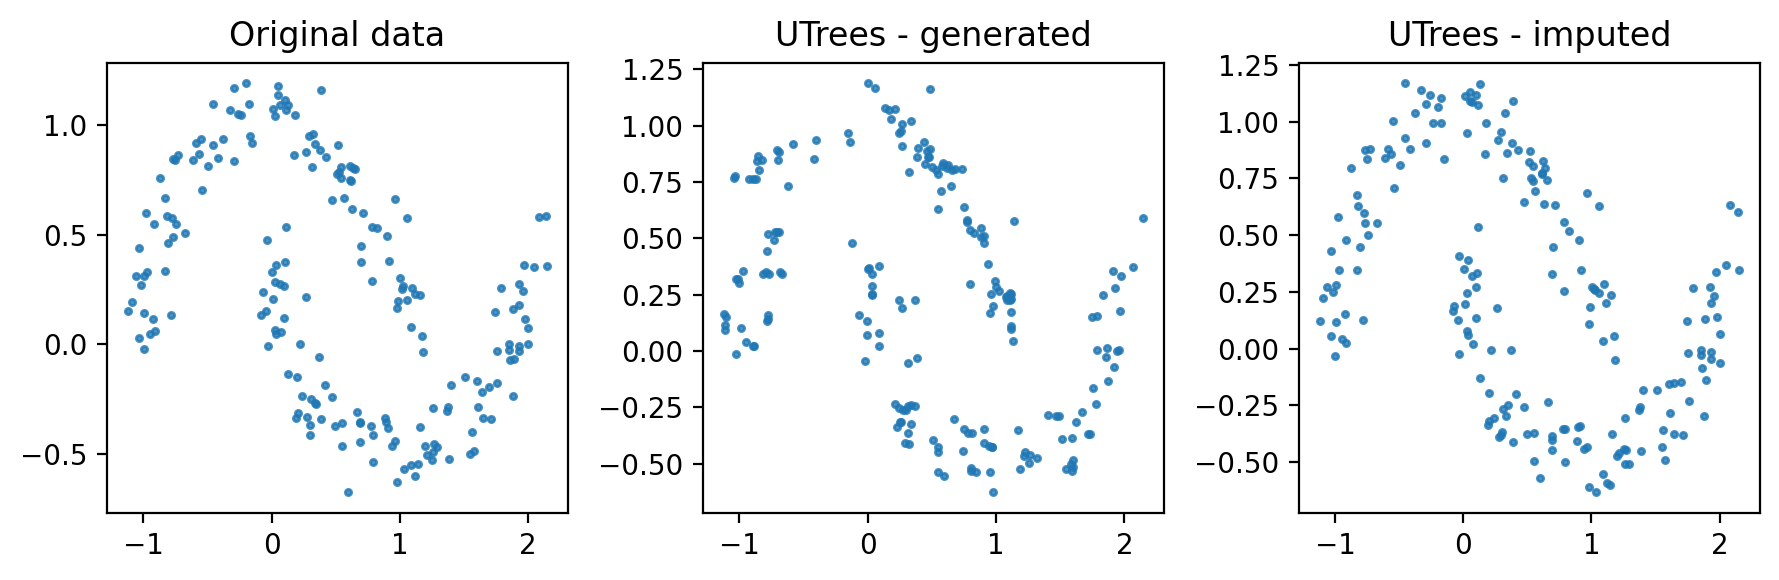

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3), squeeze=False, dpi=200);
markersize = 5
alpha = 0.8
axes[0, 0].scatter(data[:, 0], data[:, 1], s=markersize, alpha=alpha);
axes[0, 0].set_title('Original data');
axes[0, 1].scatter(data_gen_utmodel[:, 0], data_gen_utmodel[:, 1], s=markersize, alpha=alpha);
axes[0, 1].set_title('UTrees - generated');
axes[0, 2].scatter(data_impute_utmodel[200:, 0], data_impute_utmodel[200:, 1], s=markersize, alpha=alpha);
axes[0, 2].set_title('UTrees - imputed');
plt.tight_layout();

In [4]:
# first run `pip install ForestDiffusion`
from ForestDiffusion import ForestDiffusionModel

fdmodel = ForestDiffusionModel(
    X=X,
    n_t=50, duplicate_K=100, diffusion_type='vp',
    bin_indexes=[], cat_indexes=[], int_indexes=[], n_jobs=-1)
data_gen_fdmodel = fdmodel.generate(batch_size=200)

data_impute_fdmodel_fast = fdmodel.impute(k=nimp) # regular (fast)
data_impute_fdmodel = fdmodel.impute(repaint=True, r=10, j=5, k=nimp) # REPAINT (slow, but better)

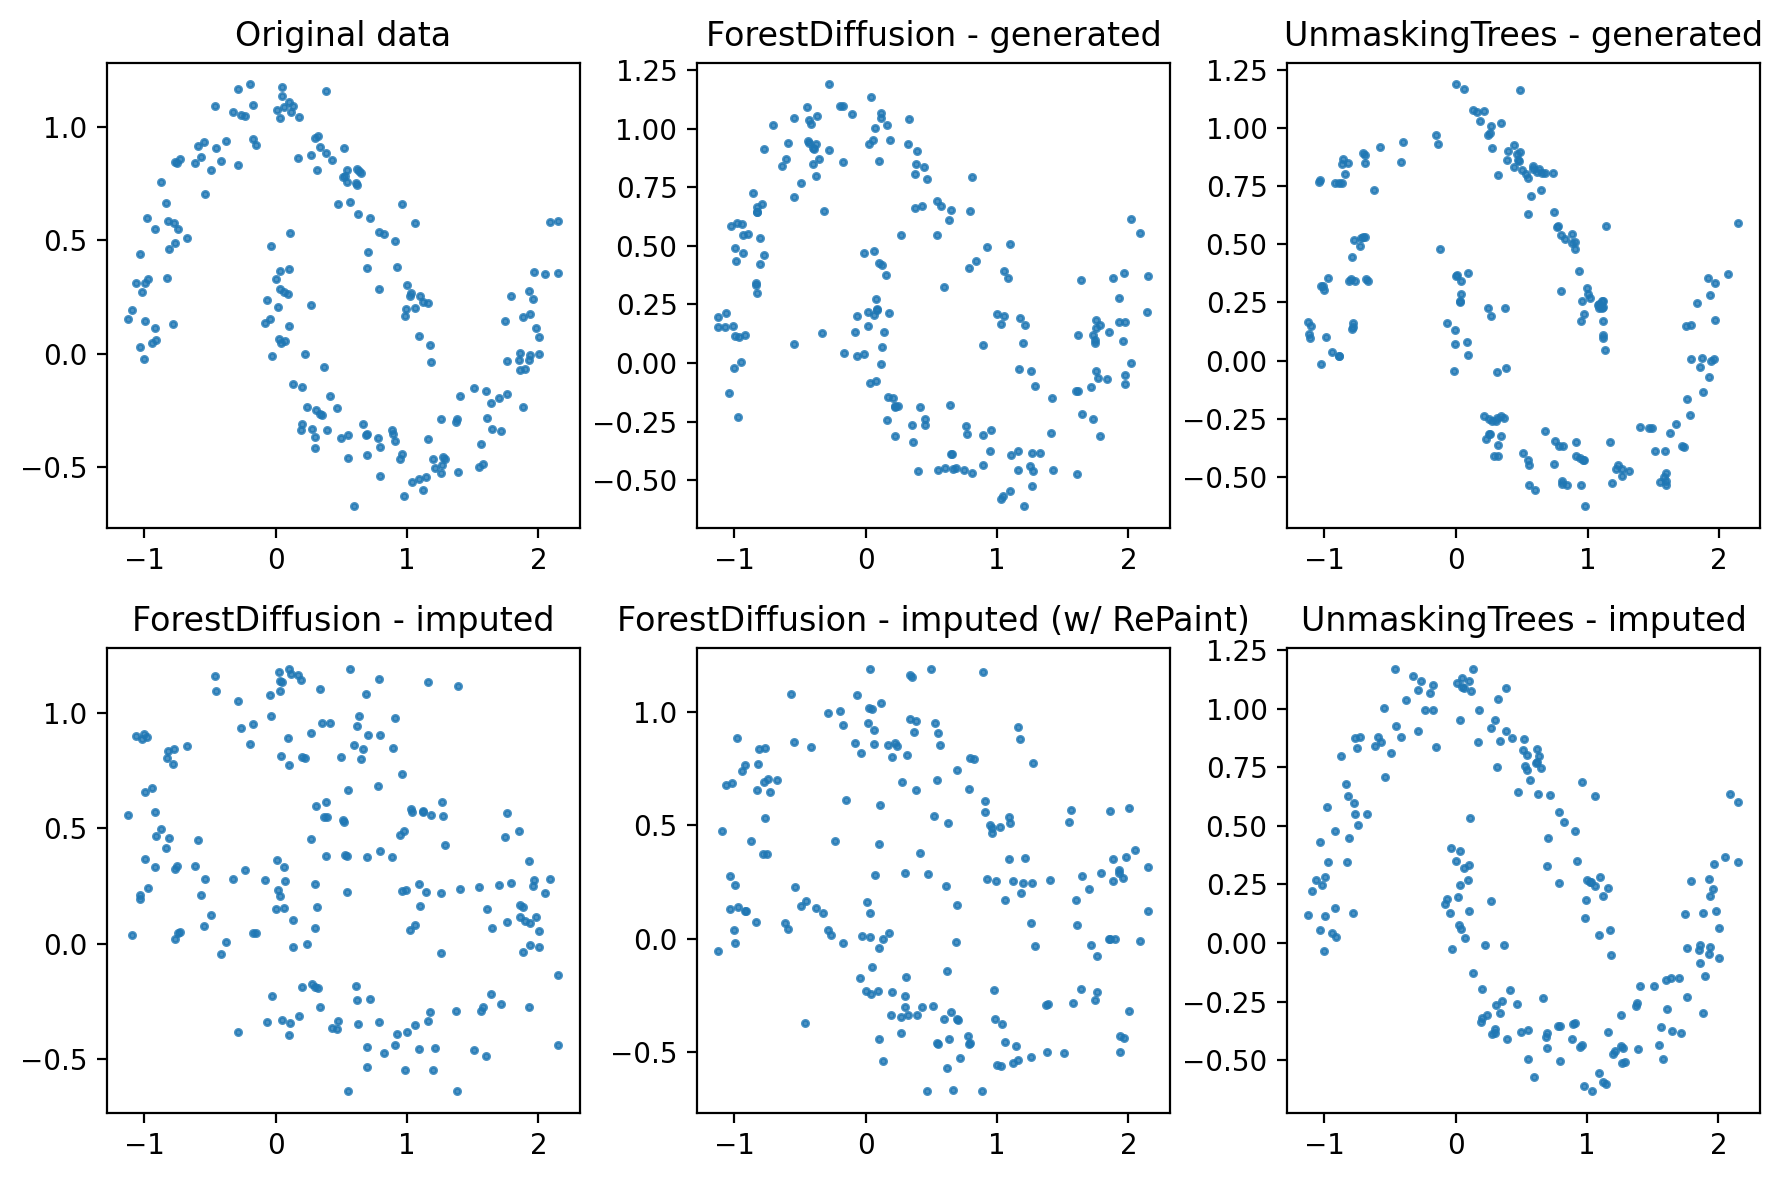

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6), squeeze=False, dpi=200);
markersize = 5
alpha = 0.8
axes[0, 0].scatter(data[:, 0], data[:, 1], s=markersize, alpha=alpha);
axes[0, 0].set_title('Original data');
axes[0, 1].scatter(data_gen_fdmodel[:, 0], data_gen_fdmodel[:, 1], s=markersize, alpha=alpha);
axes[0, 1].set_title('ForestDiffusion - generated');
axes[0, 2].scatter(data_gen_utmodel[:, 0], data_gen_utmodel[:, 1], s=markersize, alpha=alpha);
axes[0, 2].set_title('UnmaskingTrees - generated');
axes[1, 0].scatter(data_impute_fdmodel_fast[200:, 0], data_impute_fdmodel_fast[200:, 1], s=markersize, alpha=alpha);
axes[1, 0].set_title('ForestDiffusion - imputed');
axes[1, 1].scatter(data_impute_fdmodel[200:, 0], data_impute_fdmodel[200:, 1], s=markersize, alpha=alpha);
axes[1, 1].set_title('ForestDiffusion - imputed (w/ RePaint)');
axes[1, 2].scatter(data_impute_utmodel[200:, 0], data_impute_utmodel[200:, 1], s=markersize, alpha=alpha);
axes[1, 2].set_title('UnmaskingTrees - imputed');
plt.tight_layout();
plt.savefig('moons-demo.png');

In [6]:
xbins = utmodel.encoders_[0][0].bin_edges_[0]
xeval = (xbins[1:] + xbins[:-1]) / 2
ybins = utmodel.encoders_[1][0].bin_edges_[0]
yeval = (ybins[1:] + ybins[:-1]) / 2
dX1, dX2 = np.meshgrid(xeval,  yeval)
dX = np.stack([dX1.ravel(), dX2.ravel()], axis=1)
scores = utmodel.score_samples(dX, n_evals=10)

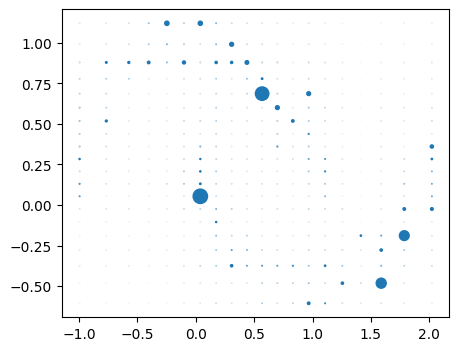

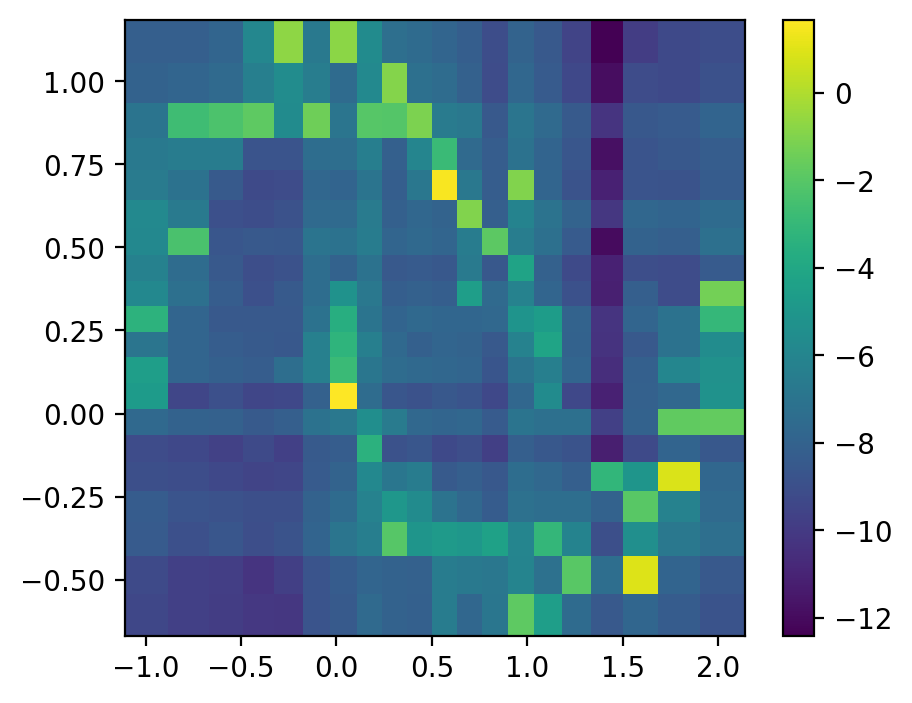

In [7]:
plt.figure(figsize=(5,4));
plt.scatter(dX[:, 0], dX[:, 1], s=20*np.exp(scores));

plt.figure(figsize=(5,4), dpi=200);
plt.pcolormesh(dX1, dX2, scores.reshape(dX1.shape));
#plt.axis('equal');
plt.colorbar();
plt.savefig('moons-demo-loglik.png');